# 06 — Results Aggregation and Statistical Testing

This notebook will aggregate JSON reports, summary tables and statistical analyses of the models.

In [5]:
import pandas as pd, json, glob, os
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

files = glob.glob("../results/models/*.json", recursive=True)
records = []
for f in files:
    if "regression" not in f.lower():   
        continue
    with open(f) as j:
        d = json.load(j)
        d["model"] = Path(f).stem.replace("_test_report","") 
        records.append(d)
df = pd.DataFrame(records)
df.head()

,best_params,cv_r2_mean,cv_r2_per_fold,model,r2_score,adjusted_r2,mae,mse,rmse,pearson_r
0,"{'criterion': 'absolute_error', 'max_depth': N...",0.448695,"[-0.008190948293268496, 0.891254537287193, 0.4...",DecisionTree_Regression_cv,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,DecisionTree_regression,0.796172,0.796172,0.042927,0.002745,0.052394,0.916207
2,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.628263,"[0.6266390118690099, 0.7775329941121027, 0.774...",KNN_Regression_cv,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,kNN_regression,0.805847,0.805847,0.040873,0.002615,0.051135,0.912658
4,{'alpha': 0.001},0.900197,"[0.9087553826263375, 0.9638195424992607, 0.922...",Lasso_Regression_cv,NaN,NaN,NaN,NaN,NaN,NaN


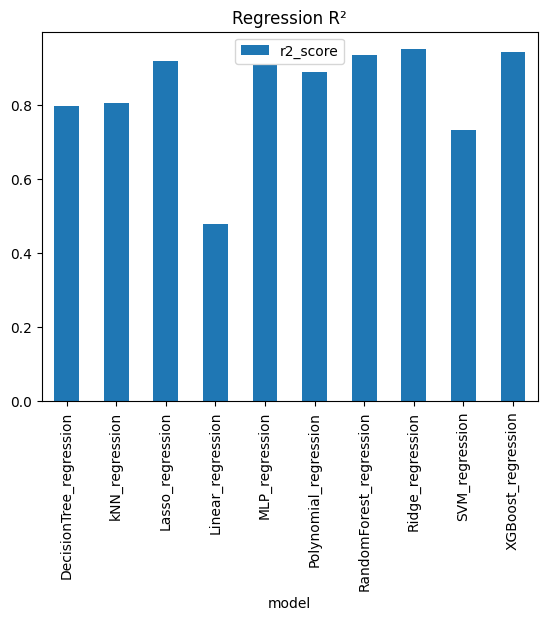

In [6]:
# Plot summary bars for regression R²
reg = df[df["model"].str.contains("regression")]
reg.plot.bar(x="model", y="r2_score", title="Regression R²")
output_path = os.path.join("../results/plots", "Regression_R^2_Table.png")
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()

RandomForest CV R² per-fold: [0.7698557403918665, 0.8075106693501437, 0.7895764979536288, 0.6708366287678562, 0.7071514188816528]
SVM CV R² per-fold: [0.4856975399525615, 0.7419039979556681, 0.6907941288305635, 0.4316139453690687, 0.548121046684584]
KNN CV R² per-fold: [0.6266390118690099, 0.7775329941121027, 0.7749272896134192, 0.3433862972949343, 0.6188302750737364]
Linear CV R² per-fold: [0.335161336955519, 0.9299813256500253, 0.8431656583281544, 0.7284799049660255, 0.7717159707632819]
Ridge CV R² per-fold: [0.7444855800927559, 0.9520067000271579, 0.9380760471017657, 0.8459448070191076, 0.7521974128010033]
Lasso CV R² per-fold: [0.9087553826263375, 0.9638195424992607, 0.9222242147196275, 0.9071527190211466, 0.7990310745716632]
Polynomial CV R² per-fold: [0.4558615816759324, 0.8743880099030674, 0.8989350018595637, 0.7736905166382019, 0.6992781660905878]
MLP CV R² per-fold: [0.838285665604583, 0.8185476984182269, 0.7489021032346137, 0.34780345629884213, 0.8318609924978125]
XGBoost CV 

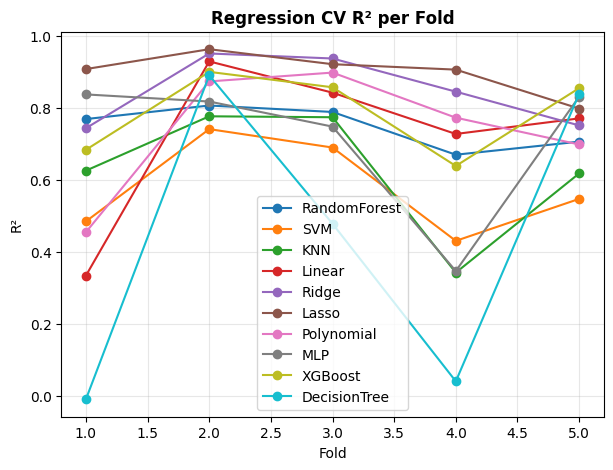


=== Paired t-test Results (RandomForest vs Others) ===
          Model  t_statistic  p_value
0           SVM        4.113    0.015
1           KNN        2.138    0.099
2        Linear        0.266    0.803
3         Ridge       -2.576    0.062
4         Lasso       -6.366    0.003
5    Polynomial        0.108    0.919
6           MLP        0.410    0.703
7       XGBoost       -0.912    0.413
8  DecisionTree        1.639    0.177


In [7]:
# ---- Load CV JSONs for regression models ----
def load_cv_scores(model_name, metric_key="cv_r2_per_fold", base_dir="../results/models"):
    """Utility to load per-fold CV scores or fall back to single summary value."""
    path = Path(base_dir) / f"{model_name}_cv.json"
    if not path.exists():
        raise FileNotFoundError(f"No CV file found for {model_name} in {base_dir}")
    with open(path) as f:
        d = json.load(f)
    # Prefer per-fold scores if present, otherwise wrap single value
    return d.get(metric_key) or [d.get("cv_f1_macro") or d.get("cv_r2_mean")]

# compare regression CV R² between RandomForest and SVM
rf_cv = load_cv_scores("RandomForest_Regression", metric_key="cv_r2_per_fold")
svm_cv = load_cv_scores("SVM_Regression", metric_key="cv_r2_per_fold")
knn_cv = load_cv_scores("KNN_Regression", metric_key="cv_r2_per_fold")
linear_cv = load_cv_scores("Linear_Regression", metric_key="cv_r2_per_fold")
ridge_cv = load_cv_scores("Ridge_Regression", metric_key="cv_r2_per_fold")
lasso_cv = load_cv_scores("Lasso_Regression", metric_key="cv_r2_per_fold")
poly_cv = load_cv_scores("Polynomial_Regression", metric_key="cv_r2_per_fold")
mlp_cv = load_cv_scores("MLP_Regression", metric_key="cv_r2_per_fold")
xgb_cv = load_cv_scores("XGBoost_Regression", metric_key="cv_r2_per_fold")
dt_cv = load_cv_scores("DecisionTree_Regression", metric_key="cv_r2_per_fold")

Regress_models_cv = {
    "RandomForest": rf_cv,
    "SVM": svm_cv,
    "KNN": knn_cv,
    "Linear": linear_cv,
    "Ridge": ridge_cv,
    "Lasso": lasso_cv,
    "Polynomial": poly_cv,
    "MLP": mlp_cv,
    "XGBoost": xgb_cv,
    "DecisionTree": dt_cv
}

for model, scores in Regress_models_cv.items():
    print(f"{model} CV R² per-fold: {scores}")

paired_test_results = {}
# ---- Paired t-test ----
for model, scores in Regress_models_cv.items():
    # calculate paired t-test against RandomForest
    if model == "RandomForest":
        continue
    if len(rf_cv) == len(scores) and len(rf_cv) > 1:
        t, p = ttest_rel(rf_cv, scores)
        print(f"Paired t-test (RF vs {model}): t={t:.3f}, p={p:.3f}")
        paired_test_results[model] = {"t_statistic": t, "p_value": p}
    else:
        print(f"Not enough per-fold values for t-test (RF vs {model}, need ≥2 and equal length).")


# Save 
cv_df = pd.DataFrame({
    "Fold": range(1, len(rf_cv) + 1),
    "RandomForest": rf_cv,
    "SVM": svm_cv,
    "KNN": knn_cv,
    "Linear": linear_cv,
    "Ridge": ridge_cv,
    "Lasso": lasso_cv,
    "Polynomial": poly_cv,
    "MLP": mlp_cv,
    "XGBoost": xgb_cv,
    "DecisionTree": dt_cv
}).melt(id_vars="Fold", var_name="Model", value_name="R²")

# ---- Plot per-fold comparison ----
plt.figure(figsize=(7, 5))
for model in cv_df["Model"].unique():
    subset = cv_df[cv_df["Model"] == model]
    plt.plot(subset["Fold"], subset["R²"], marker="o", label=model)

plt.title("Regression CV R² per Fold", fontsize=12, weight="bold")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.legend()
plt.grid(alpha=0.3)

# ---- Save to file ----
output_path = Path("../results/plots") / "Regression_CV_R2_Comparison.png"
plt.savefig(output_path, bbox_inches="tight", dpi=300)
plt.show()

# create table displaring paired t-test results
# ---- Convert t-test results to DataFrame ----
paired_df = pd.DataFrame.from_dict(paired_test_results, orient="index")
paired_df.index.name = "Model"
paired_df.reset_index(inplace=True)

# Round for readability
paired_df["t_statistic"] = paired_df["t_statistic"].round(3)
paired_df["p_value"] = paired_df["p_value"].round(3)

print("\n=== Paired t-test Results (RandomForest vs Others) ===")
print(paired_df)

# ---- Save as JSON and CSV ----
output_path_json = Path("../results/models") / "Regression_CV_R2_Paired_TTest_Results.json"
output_path_csv = Path("../results/models") / "Regression_CV_R2_Paired_TTest_Results.csv"

with open(output_path_json, "w") as f:
    json.dump(paired_test_results, f, indent=2)

paired_df.to_csv(output_path_csv, index=False)

